In [32]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pulp as p 
import time

In [33]:
(x, y, z, v, w, t) = sp.var("x y z v w t")

In [34]:
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Pulp:", p.__version__)

NumPy: 1.26.4
Pandas: 2.2.2
Pulp: 2.8.0


## Metodo Newton Multivariable

In [35]:
def newton_method(
    function: any,
    variables: list[any] | tuple[any],
    point: list[float] | tuple[float],
    tol: float = 0.01,
    min_value: float = 1e9,
    max_iter: int = 100,
    print_solutions: bool = False,
) -> None:

    expression = function(*variables)
    grad = [sp.diff(expression, var) for var in variables]
    H = sp.hessian(expression, variables)

    for i in range(max_iter):

        J = [g.subs(zip(variables, point)) for g in grad]
        H_eval = H.subs(zip(variables, point))
        current_value = function(*point)

        if abs(min_value - current_value) < tol:
            solution = (current_value, tuple(point))

            if print_solutions:
                print(f"Solucion {solution}\nIteraciones: {i}")

            return solution

        min_value = current_value

        H_eval = H.subs(zip(variables, point))
        H_eval = np.array(H_eval, dtype="float")
        H_inv = np.linalg.inv(H_eval)
        point = point - H_inv @ J


In [36]:
(x, y, z, v, w, t) = sp.symbols("x y z v w t")

f = lambda x, y: 3 * x**2 + 2 * y**2 + x + 10
newton_method(f, (x, y), (5, 5), print_solutions=True)

Solucion (9.91666666666667, (-0.166666666666667, 0))
Iteraciones: 2


(9.91666666666667, (-0.166666666666667, 0))

### Con puntos aleatorios

In [37]:
def newton_random(
    function: any,
    variables: list[any] | tuple[any],
    initial_bounds: tuple[float] | list[float],
    tol: float = 0.01,
    min_value: float = 1e9,
    max_iters: list[int] = [100],
    num_random_points: int = 10,
    get_time: bool = False,
    print_solutions: bool = False,
) -> tuple:

    info_collected = {}
    time_dict = {}

    if isinstance(max_iters, int):
        max_iters = [max_iters]

    for i in max_iters:
        start_time = time.perf_counter()
        solutions = []
        for _ in range(num_random_points):
            random_point = np.random.uniform(*initial_bounds, len(variables))

            solution = newton_method(
                function, variables, random_point, tol, min_value, i, print_solutions
            )
            if solution:
                solutions.append(solution)

        info_collected[i] = solutions

        end_time = time.perf_counter() - start_time
        time_dict[i] = end_time

    if get_time:
        return info_collected, time_dict

    return info_collected

In [38]:
initial_bounds = -20000, 10000
solution, times = newton_random(f, (x, y), initial_bounds, tol=0.01, get_time=True)

### Graficar espacio

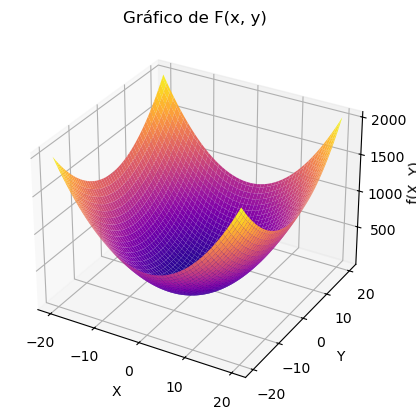

In [39]:
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)

Z = f(X, Y) # Funcion objetivo

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X, Y)')
ax.set_title('Gráfico de F(x, y)')

plt.show()

### Graficar contorno

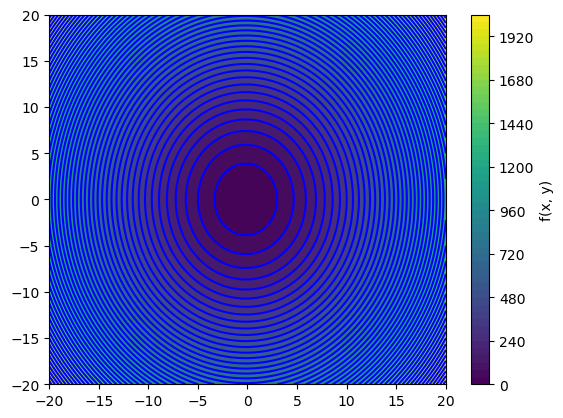

In [40]:
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='f(x, y)')
plt.contour(X, Y, Z, levels=50, colors='blue')

## Metodo de descenso de gradiente

In [41]:
def gradient_descent_method(
    function: callable,
    variables: list[any] | tuple[any],
    point: list[float] | tuple[float],
    alpha: float = 0.01,
    tol: float = 0.01,
    min_value: float = 1e9,
    max_iter: int = 100,
    print_solutions: bool = False,
) -> tuple[float, tuple]:

    expression = function(*variables)
    grad = [sp.diff(expression, var) for var in variables]

    for i in range(max_iter):

        # Se ve feo, pero es solo para estandarizar el formato
        J = np.array([float(g.subs(dict(zip(variables, point)))) for g in grad])
        current_value = float(expression.subs(dict(zip(variables, point))))

        if np.isnan(current_value) or np.isinf(current_value):
            break

        if abs(min_value - current_value) < tol:
            solution = (current_value, tuple(point))

            if print_solutions:
                print(f"Solucion {solution}\nIteraciones: {i}")

            return solution

        min_value = current_value

        point = (
            np.array(point, dtype="float") - alpha * J
        )

    return None

### Usar numeros aleatorios

In [42]:
def gradient_method_random(
    function: callable,
    variables: list[any] | tuple[any],
    initial_bounds: tuple[float] | list[float],
    alpha: float = 0.01,
    tol: float = 0.001,
    min_value: float = 1e9,
    max_iters: list[int] = [100],
    num_random_points: int = 10,
    get_time: bool = False,
    print_solutions: bool = False
) -> tuple:
    info_collected = {}
    time_dict = {}

    if isinstance(max_iters, int):
        max_iters = [max_iters]

    for i in max_iters:
        start_time = time.perf_counter()
        solutions = []

        for _ in range(num_random_points):
            random_point = np.random.uniform(*initial_bounds, len(variables))

            solution = gradient_descent_method(
                function, variables, random_point, alpha, tol, min_value, i, print_solutions
            )
            if solution:
                solutions.append(solution)

        info_collected[i] = solutions

        end_time = time.perf_counter() - start_time
        time_dict[i] = end_time
    if get_time:
        return info_collected, time_dict

    return info_collected

In [43]:
x, y, z = sp.var(" x y z ")

f2 = lambda x, y, z: x**2 + y**2 + z
solutions, times = gradient_method_random(f2, (x, y, z), initial_bounds=(-20, 20), alpha=0.001, tol=0.1, get_time=True, max_iters=[100, 200, 300, 400])

print(solutions)

{100: [], 200: [], 300: [(35.47079228920581, (-3.4360516061444084, -3.1369322579679166, 13.823997658038548))], 400: [(24.83060431857469, (-1.6751896477597945, -3.9943694183747986, 6.06935691216528)), (4.557876950701882, (4.3572589377957565, 2.3667136970450047, -20.029162224079556))]}


### Graficar tiempos

Text(0, 0.5, 'Tiempo de Cómputo')

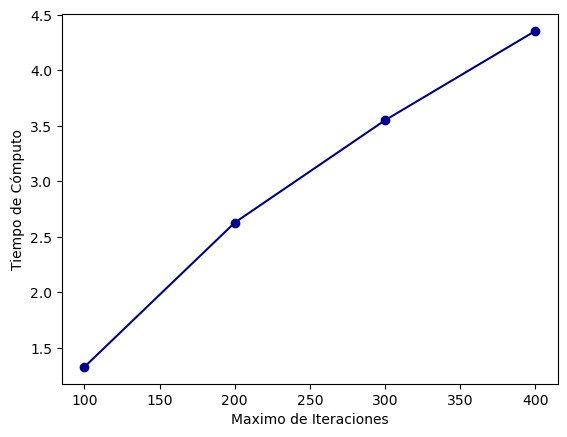

In [44]:
plt.plot(times.keys(), times.values(), "o-", color = "darkblue")
plt.xlabel("Maximo de Iteraciones")
plt.ylabel("Tiempo de Cómputo")

In [45]:
def clean_solutions(
    solutions: dict[int, list[tuple]], decimal_places: int = 3
) -> dict[int, list[tuple]]:
    cleaned_solutions = {}

    for key, value_list in solutions.items():
        unique_values = []
        seen_values = set()

        for value, point in value_list:
            rounded_value = round(value, decimal_places)
            if rounded_value not in seen_values:
                seen_values.add(rounded_value)
                unique_values.append((value, point))

        cleaned_solutions[key] = unique_values

    return cleaned_solutions

In [53]:
uniques_solutions = clean_solutions(solutions)
uniques_solutions

{100: [],
 200: [],
 300: [(35.47079228920581,
   (-3.4360516061444084, -3.1369322579679166, 13.823997658038548))],
 400: [(24.83060431857469,
   (-1.6751896477597945, -3.9943694183747986, 6.06935691216528)),
  (4.557876950701882,
   (4.3572589377957565, 2.3667136970450047, -20.029162224079556))]}

## Programacion lineal

### Planificacion de Produccion

In [47]:
model = p.LpProblem("Scheduling_problem", p.LpMinimize)


factory_path = "factory_variables.csv"
demand_path = "monthly_demand.csv"

factories = pd.read_csv(factory_path, index_col=["Month", "Factory"])
demand = pd.read_csv(demand_path, index_col=["Month"])

In [ ]:
production = p.LpVariable.dicts(
    "production",
    ((month, factory) for month, factory in factories.index),
    lowBound=0,
    cat="Integer",
)

factory_status = p.LpVariable.dicts(
    "factory_status",
    ((month, factory) for month, factory in factories.index),
    cat="Binary",
)


# Objective Function:

model += p.lpSum(
    [
        production[month, factory] * factories.loc[(month, factory), "Variable_Costs"]
        for month, factory in factories.index
    ]
    + [
        factory_status[month, factory] * factories.loc[(month, factory), "Fixed_Costs"]
        for month, factory in factories.index
    ]
)


# Restrictions
# Demand: monthly production in A+B = monthly demand
months = demand.index
for month in months:
    model += (
        production[(month, "A")] + production[(month, "B")]
        == demand.loc[month, "Demand"]
    )

# Production in any month must be between minimum and maximum capacity, or zero.
for month, factory in factories.index:
    min_production = factories.loc[(month, factory), "Min_Capacity"]
    max_production = factories.loc[(month, factory), "Max_Capacity"]
    model += (
        production[(month, factory)] >= min_production * factory_status[month, factory]
    )
    model += (
        production[(month, factory)] <= max_production * factory_status[month, factory]
    )


model += factory_status[5, "B"] == 0
model += production[5, "B"] == 0



model.solve()

print("Status:", p.LpStatus[model.status])

output = []
for month, factory in production:
    var_output = {
        "Month": month,
        "Factory": factory,
        "Production": production[(month, factory)].varValue,
        "Factory Status": factory_status[(month, factory)].varValue,
    }
    output.append(var_output)

output_df = pd.DataFrame(output)

In [49]:
display(output_df)

,Month,Factory,Production,Factory Status
0,1,A,70000.0,1.0
1,1,B,50000.0,1.0
2,2,A,45000.0,1.0
3,2,B,55000.0,1.0
4,3,A,70000.0,1.0
5,3,B,60000.0,1.0
6,4,A,30000.0,1.0
7,4,B,100000.0,1.0
8,5,A,140000.0,1.0
9,5,B,0.0,0.0


### Programacion Lineal MultiObjetivo

In [ ]:
x1 = p.LpVariable("A", lowBound=1, cat="Continous")
x2 = p.LpVariable("B", lowBound=0, upBound=5, cat="Continous")

Z_1 = []
Z_2 = []

alpha_values = []
obj_value = []
alphas = np.linspace(0, 1, 100)

for alpha in alphas:
    linearProblem = p.LpProblem("Multi_objetive_minimizatio", p.LpMinimize)
    linearProblem += alpha * (4 * x1 - x2) + (1 - alpha) * (-0.5 * x1 + x2)

    linearProblem += 2 * x1 + x2 <= 8
    linearProblem += x1 - x2 <= 4

    solution = linearProblem.solve()

    z1 = 4 * p.value(x1) - p.value(x2)
    z2 = -0.5 * p.value(x1) + p.value(x2)

    Z_1.append(z1)
    Z_2.append(z2)
    alpha_values.append(alpha)
    obj_value.append(p.value(linearProblem.objective))



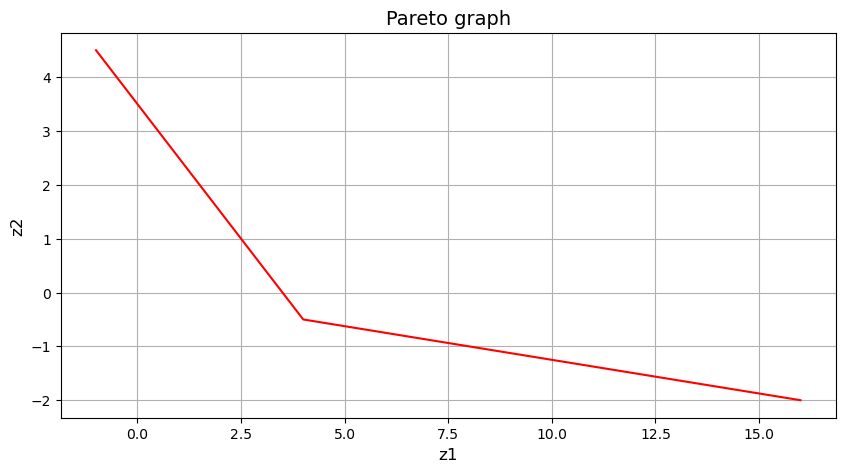

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(Z_1, Z_2, color="red")
plt.xlabel("z1", size=12)
plt.ylabel("z2", size=12)
plt.title("Pareto graph", size=14)
plt.grid(True)
plt.show()

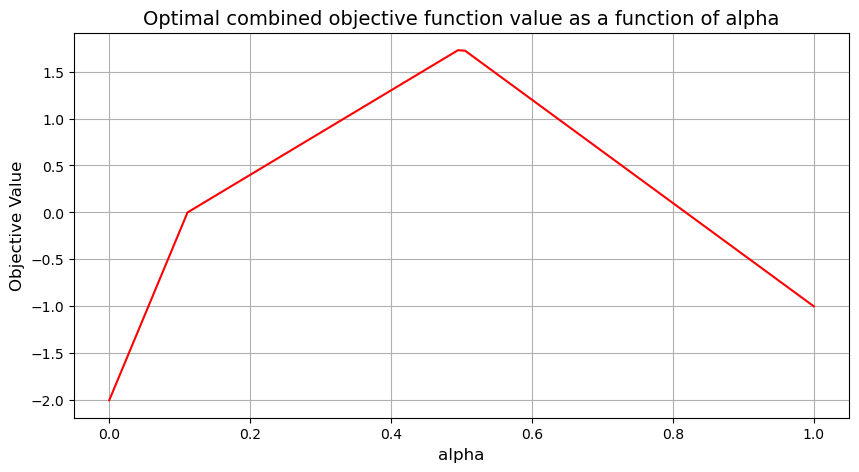

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(alpha_values, obj_value, color="red")
plt.xlabel("alpha", size=12)
plt.ylabel("Objective Value", size=12)
plt.title("Optimal combined objective function value as a function of alpha", size=14)
plt.grid(True)
plt.show()